########################################################

#Copyright (c) DeepSphere.AI 2021

# All rights reserved

# We are sharing this partial code for learning and research, and the idea behind us sharing the source code is to stimulate ideas #and thoughts for the learners to develop their Computer Vision knowledge.

# Author: # DeepSphere.AI | deepsphere.ai | dsschoolofai.com | info@deepsphere.ai

# Release: Initial release

#######################################################

The data used for training the model is UTKFace data. 

Following commands can be used to access data:

!git clone https://github.com/Deepsphere-AI/IndustryUseCases/blob/master/DSAI_Oops_patient_segmentation/DSAI_Patient_Segmentation_data.zip
                      or
!wget https://github.com/Deepsphere-AI/IndustryUseCases/blob/master/DSAI_Oops_patient_segmentation/DSAI_Patient_Segmentation_data.zip

!unzip /content/IndustryUseCases/DSAI_Oops_patient_segmentation/DSAI_Patient_Segmentation_data.zip

In [28]:
from google.colab import files
files.upload()

Saving DSAI_sml_utk.zip to DSAI_sml_utk.zip


In [48]:
from google.colab import files
files.upload()

Saving DSAI_labels.txt to DSAI_labels.txt


{'DSAI_labels.txt': b'image,age,gender,ethnicity'}

In [51]:
import zipfile
import pandas as pd
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import keras 
from keras.layers import *
from keras.models import *
from keras import backend as K
from sklearn.model_selection import train_test_split
import plotly.graph_objects as go
from datetime import datetime
from google.cloud.bigquery.client import Client

zipfile package is used to unzip the .zip file 

In [31]:
with zipfile.ZipFile('/content/DSAI_sml_utk.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/git')

CLASS      : classification

USED METHODS    : 
              init(),
             data_normalization(),
             plot_age(),
             display_sample(),
             feature_selection(),
             trantest_split(),
             model(),
             model_compile(),
             train_model(),
             model_visualisation(),
             display(),
             get_ethncty(),
             get_genders(),
             test_model()



The model used here is a multi-target CNN sequencial Keras model. A single model outputs three different variables Age, Gender and Ethnicity respectively. The model layers, dense and dropout rates are explained below.

In [129]:
class Class_Patient_Segmentation:
  def __init__(self,data_path):
    self.path = data_path
    self.files = os.listdir(self.path)
    self.images = []
    self.ages = []
    self.genders = []
    self.ethncty = []

  def data_normalization(self):
    data = []
    for file in self.files:
      image = cv2.imread(self.path+'/'+file,0)
      image = cv2.resize(image,dsize=(64,64))
      image = image.reshape((image.shape[0],image.shape[1],1))
      # plt.imshow(image)
      split_var = file.split('_')
      # print(split_var[0],split_var[1],split_var[2])
      if '.jpg' not in split_var[2]:
          self.images.append(image)
          self.ages.append(split_var[0])
          self.genders.append(int(split_var[1]))
          self.ethncty.append(int(split_var[2]))
          dt = (image,split_var[0],split_var[1],split_var[2])
          data.append(dt)
    my_file = open("DSAI_labels.txt", "r")
    labels = my_file.read()
    labels = labels.split(",")
    df = pd.DataFrame(data,columns=labels)
    gender = {"0":'Male',"1":'Female'}
    ethnicity = {'0':'White','1':'Black','2':'Asian','3':'Indian','4':'Others'}
    df = df.replace({"gender":gender,"ethnicity":ethnicity})
    print(df.head())
    return df

  def display_sample(self):
    idx = 50
    self.sample = self.images[idx]
    print("Gender:",self.genders[idx],"Age:",self.ages[idx],"Ethnicity:",self.ethncty[idx])
    plt.imshow(self.sample[:,:,0])
    plt.show()

  def plot_distribution(self,name,pd_series):
    if name.lower() == "age":
      pd_series = pd.cut(pd_series, bins=[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 120], 
                         labels=["0-10","10-20","20-30","30-40","40-50","50-60","60-70","70-80","80-90","90-100","100-120"])
    labels = pd.value_counts(pd_series).index.tolist()
    counts = pd.value_counts(pd_series).values.tolist()
    
    pie_plot = go.Pie(labels=labels, values=counts, hole=.4)
    fig = go.Figure(data=[pie_plot])
    fig.update_layout(title_text='Distribution for %s' % name)
    
    fig.show()

  def feature_selection(self):
    size = len(self.ages)
    self.target = np.zeros((size,3),dtype='float32')
    self.features = np.zeros((size,self.sample.shape[0],self.sample.shape[1],1),dtype = 'float32')
    for i in range(size):
        self.target[i,0] = int(self.ages[i])
        self.target[i,1] = int(self.genders[i])
        self.target[i,2] = int(self.ethncty[i])
        self.features[i] = self.images[i]
    self.features = self.features / 255
    return self.features[550]

  def traintest_split(self):
    self.x_train, self.x_test, self.y_train, self.y_test = train_test_split(self.features, self.target, test_size=0.2,shuffle  = True)
    print("Samples in Training:",self.x_train.shape[0])
    print("Samples in Testing:",self.x_test.shape[0])

  def model(self):
    inputs = Input(shape=(64,64,1))
    conv1 = Conv2D(32, kernel_size=(3, 3),activation='relu')(inputs)
    conv2 = Conv2D(64, kernel_size=(3, 3),activation='relu')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(128, kernel_size=(3, 3),activation='relu')(pool1)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv3)
    x = Dropout(0.25)(pool2)
    flat = Flatten()(x)

    dropout = Dropout(0.5)
    age_model = Dense(128, activation='relu')(flat)
    age_model = dropout(age_model)
    age_model = Dense(64, activation='relu')(age_model)
    age_model = dropout(age_model)
    age_model = Dense(32, activation='relu')(age_model)
    age_model = dropout(age_model)
    age_model = Dense(1, activation='relu')(age_model)

    dropout = Dropout(0.5)
    gender_model = Dense(128, activation='relu')(flat)
    gender_model = dropout(gender_model)
    gender_model = Dense(64, activation='relu')(gender_model)
    gender_model = dropout(gender_model)
    gender_model = Dense(32, activation='relu')(gender_model)
    gender_model = dropout(gender_model)
    gender_model = Dense(16, activation='relu')(gender_model)
    gender_model = dropout(gender_model)
    gender_model = Dense(8, activation='relu')(gender_model)
    gender_model = dropout(gender_model)
    gender_model = Dense(1, activation='sigmoid')(gender_model)

    dropout = Dropout(0.5)
    ethncty_model = Dense(128, activation='relu')(flat)
    ethncty_model = dropout(ethncty_model)
    ethncty_model = Dense(64, activation='relu')(ethncty_model)
    ethncty_model = dropout(ethncty_model)
    ethncty_model = Dense(32, activation='relu')(ethncty_model)
    ethncty_model = dropout(ethncty_model)
    ethncty_model = Dense(16, activation='relu')(ethncty_model)
    ethncty_model = dropout(ethncty_model)
    ethncty_model = Dense(8, activation='relu')(ethncty_model)
    ethncty_model = dropout(ethncty_model)
    ethncty_model = Dense(1, activation='relu')(ethncty_model)

    model = Model(inputs=inputs, outputs=[age_model,gender_model,ethncty_model])
    return model

  def model_compile(self,model):
    model.compile(optimizer = 'adam', loss =['mse','binary_crossentropy'],metrics=['accuracy'])
    model.summary()
    return model

  def train_model(self,model,epoch):
    self.h = model.fit(self.x_train,[self.y_train[:,0],self.y_train[:,1],self.y_train[:,2]],validation_data=(self.x_test,[self.y_test[:,0],self.y_test[:,1],self.y_test[:,2]]),epochs = int(epoch), batch_size=128,shuffle = True)
    model.save('/content/git/DSAI_model_outcome.h5')
    return model

  def model_visualisation(self):
    history = self.h
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
  
  def display(self,img):
    plt.imshow(img[:,:,0])
    plt.show()
  
  def get_age(self,res):
    if res>=0 and res<10 : return "0-10"
    elif res>=10 and res<20 : return "10-20"
    elif res>=20 and res<30 : return "20-30"
    elif res>=30 and res<40 : return "30-40"
    elif res>=40 and res<50 : return "40-50"
    elif res>=50 and res<60 : return "50-60"
    elif res>=60 and res<70 : return "60-70"
    elif res>=70 and res<80 : return "70-80"
    elif res>=80 and res<90 : return "80-90"
    elif res>=90 and res<100 : return "90-100"
    elif res>=100 and res<120 : return "100-120"
    else : return "Ungrouped"
    
  def get_ethncty(self,res):
      # 0 to 4, denoting White, Black, Asian, Indian, and Other
      if res == 0:
        return "White"
      elif res == 1:
        return "Black"
      elif res == 2:
        return "Asian"
      elif res == 3:
        return "Indian"
      else: return "Others"
      
  def get_genders(self,prob):
      if prob < 0.5:return "Male"
      else: return "Female"

  def get_result(self,sample,model):
      sample = sample/255
      val = model.predict( np.array([ sample ]) ) 
      return val 
  def write_output_BQ(self,op_data,path):
    key = path
    client = Client.from_service_account_json(, project='big-query-testdp-328205')
    df = client.query('''
    SELECT Model_Run_Id as Id FROM `big-query-testdp-328205.DSAI_PATIENT_CLASSIFICATION.DSAI_CNN_outcome`''').to_dataframe()
    if not df.empty:
      df = df.astype(int)
      vAR_id = np.max(df['Id'])
      op_data['Model_Run_Id'] += vAR_id
    op_data = op_data.astype(str)
    tableRef = client.dataset("DSAI_PATIENT_CLASSIFICATION").table("DSAI_CNN_outcome")
    bigqueryJob = client.load_table_from_dataframe(op_data, tableRef)
    bigqueryJob.result()  


Model-Layer description:

    inputs -> Input() 
    conv1  -> Conv2D()(inputs) 
    conv2  -> Conv2D()(conv1)
    pool1  -> MaxPooling2D()(conv2)
    conv3  -> Conv2D()(pool1)
    pool2  -> MaxPooling2D()(conv3)
The input layer is of size 32 with the kernel size [3,3] and relu as activation function. The base model is constructed with relu function and    futhur customised for each target. The dropout rate is kept at 0.5 for all three outputs. The output layer is defined with sigmoid activation 
function for age and ethnicity. The get functions retrive thier original format from the model array outputs.



                                               image age gender ethnicity
0  [[[8], [13], [6], [17], [27], [42], [61], [73]...  27   Male     Asian
1  [[[169], [158], [156], [156], [148], [145], [1...  26   Male    Indian
2  [[[140], [140], [147], [152], [157], [148], [1...  62   Male     White
3  [[[247], [101], [19], [8], [11], [8], [7], [7]...  35   Male    Indian
4  [[[18], [18], [18], [17], [15], [18], [23], [8...  65   Male     White


Gender: 0 Age: 60 Ethnicity: 0


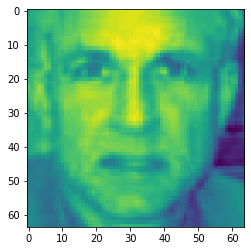

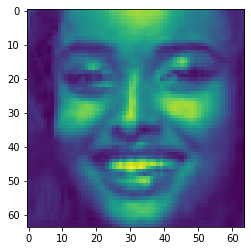

Samples in Training: 8381
Samples in Testing: 2096
Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 64, 64, 1)]  0           []                               
                                                                                                  
 conv2d_18 (Conv2D)             (None, 62, 62, 32)   320         ['input_7[0][0]']                
                                                                                                  
 conv2d_19 (Conv2D)             (None, 60, 60, 64)   18496       ['conv2d_18[0][0]']              
                                                                                                  
 max_pooling2d_12 (MaxPooling2D  (None, 30, 30, 64)  0           ['conv2d_19[0][0]']              
 )                                       

66/66 [==============================] - 172s 3s/step - loss: 719.8148 - dense_99_loss: 719.0530 - dense_105_loss: 0.7618 - dense_99_accuracy: 0.0130 - dense_105_accuracy: 0.5625 - dense_111_accuracy: 0.4449 - val_loss: 365.0047 - val_dense_99_loss: 364.3148 - val_dense_105_loss: 0.6900 - val_dense_99_accuracy: 0.0138 - val_dense_105_accuracy: 0.6050 - val_dense_111_accuracy: 0.4552


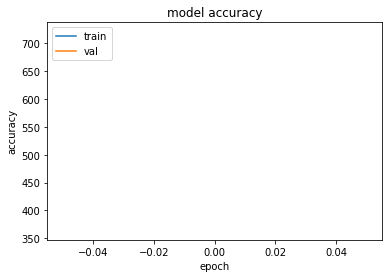

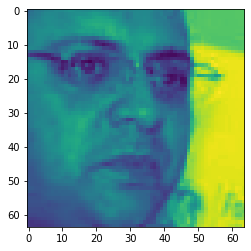

ACTUAL 
 Gender: Male Age: 51 Ethnicity Indian

PREDICTED 
MODEL OUTCOME: [array([[27.595238]], dtype=float32), array([[0.49205762]], dtype=float32), array([[0.00124836]], dtype=float32)] 
Predicted Gender: Male 
Predicted Age-group: 20-30 
Predicted ethnicity Others


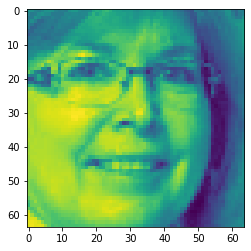

ACTUAL 
 Gender: Female Age: 49 Ethnicity White

PREDICTED 
MODEL OUTCOME: [array([[26.007895]], dtype=float32), array([[0.4921443]], dtype=float32), array([[0.]], dtype=float32)] 
Predicted Gender: Male 
Predicted Age-group: 20-30 
Predicted ethnicity White


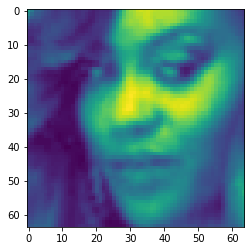

ACTUAL 
 Gender: Female Age: 38 Ethnicity Black

PREDICTED 
MODEL OUTCOME: [array([[21.354391]], dtype=float32), array([[0.4920467]], dtype=float32), array([[0.00466665]], dtype=float32)] 
Predicted Gender: Male 
Predicted Age-group: 20-30 
Predicted ethnicity Others


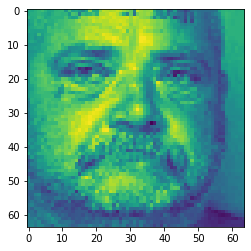

ACTUAL 
 Gender: Male Age: 62 Ethnicity White

PREDICTED 
MODEL OUTCOME: [array([[31.125237]], dtype=float32), array([[0.49215826]], dtype=float32), array([[0.]], dtype=float32)] 
Predicted Gender: Male 
Predicted Age-group: 30-40 
Predicted ethnicity White


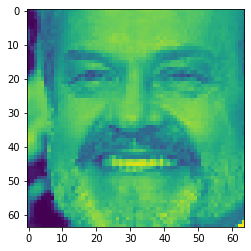

ACTUAL 
 Gender: Male Age: 59 Ethnicity White

PREDICTED 
MODEL OUTCOME: [array([[32.830776]], dtype=float32), array([[0.49210322]], dtype=float32), array([[0.]], dtype=float32)] 
Predicted Gender: Male 
Predicted Age-group: 30-40 
Predicted ethnicity White


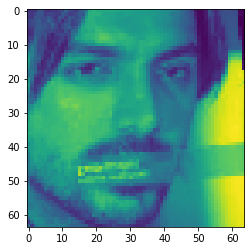

ACTUAL 
 Gender: Male Age: 27 Ethnicity Indian

PREDICTED 
MODEL OUTCOME: [array([[28.291866]], dtype=float32), array([[0.49213275]], dtype=float32), array([[0.]], dtype=float32)] 
Predicted Gender: Male 
Predicted Age-group: 20-30 
Predicted ethnicity White


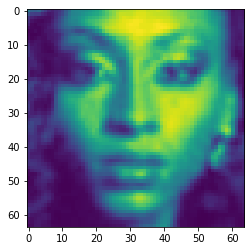

ACTUAL 
 Gender: Female Age: 38 Ethnicity Black

PREDICTED 
MODEL OUTCOME: [array([[25.884672]], dtype=float32), array([[0.49198803]], dtype=float32), array([[0.00238877]], dtype=float32)] 
Predicted Gender: Male 
Predicted Age-group: 20-30 
Predicted ethnicity Others


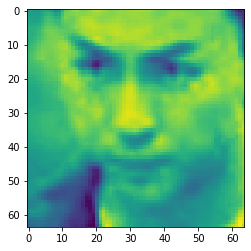

ACTUAL 
 Gender: Male Age: 26 Ethnicity Asian

PREDICTED 
MODEL OUTCOME: [array([[31.360939]], dtype=float32), array([[0.49205938]], dtype=float32), array([[0.]], dtype=float32)] 
Predicted Gender: Male 
Predicted Age-group: 30-40 
Predicted ethnicity White


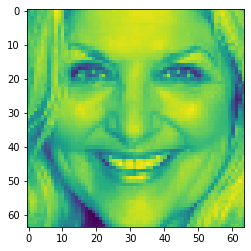

ACTUAL 
 Gender: Female Age: 56 Ethnicity White

PREDICTED 
MODEL OUTCOME: [array([[34.85829]], dtype=float32), array([[0.49205345]], dtype=float32), array([[0.]], dtype=float32)] 
Predicted Gender: Male 
Predicted Age-group: 30-40 
Predicted ethnicity White


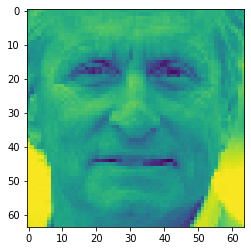

ACTUAL 
 Gender: Male Age: 69 Ethnicity White

PREDICTED 
MODEL OUTCOME: [array([[34.557568]], dtype=float32), array([[0.4920769]], dtype=float32), array([[0.]], dtype=float32)] 
Predicted Gender: Male 
Predicted Age-group: 30-40 
Predicted ethnicity White


In [130]:
if __name__ == '__main__':
  op_lst = []
  data_path = '/content/git/utkcropped'
  #creating an instance of the Class_Patient_Segmentation 
  obj = Class_Patient_Segmentation(data_path)

  # data_normalization extracts the data from file name and returns a data_frame of images with the respective age, gender and ethnicity.
  vAR_data = obj.data_normalization()
  # print(vAR_data.info())

  # plot_distribution plots a donut chart according to the passed df.column 
  obj.plot_distribution('Gender',vAR_data['gender'])
  obj.plot_distribution('Ethnicity',vAR_data['ethnicity'])
  # data['age'] = data.age.astype(int)
  obj.plot_distribution('age',vAR_data.age.astype(int))

  # display_sample plots a random image 
  obj.display_sample()

  # feature_selection is to seggregate the target variables and the feature image
  vAR_pic = obj.feature_selection()
  obj.display(vAR_pic)

  # traintest_split() splits the train and test datasets at the ratio 8:2 
  obj.traintest_split()

  # method model returns the combined model of base model inputs and our three outputs
  vAR_model = obj.model()
  
  # method model_compile uses .compile function in keras
  vAR_compiled_model = obj.model_compile(vAR_model)
  
  # train_model takes in the compiled model as input and saves the trained model at /content/git/DSAI_model_outcome.h5
  epochs = input("Enter epochs")
  vAR_trained_model = obj.train_model(vAR_compiled_model,epochs)
  
  # model_visualisation plots the saved model loss over each epoch
  obj.model_visualisation()

  indexes = [500,59,80,2,4741,1278,2587,789,3891,230]
  date_time = datetime.now()
  for idx in indexes:
      dict = {}
      sample = obj.images[idx]
      obj.display(sample)
      print("ACTUAL \n Gender:",obj.get_genders(obj.genders[idx]),"Age:",obj.ages[idx],"Ethnicity",obj.get_ethncty(obj.ethncty[idx]))
      res = obj.get_result(sample,vAR_trained_model)
      age = round(res[0][0][0])
      print("\nPREDICTED \nMODEL OUTCOME:",res,"\nPredicted Gender:",obj.get_genders(res[1]),"\nPredicted Age-group:",obj.get_age(age),"\nPredicted ethnicity",obj.get_ethncty(res[2]))
      dict = {'Model_Run_Id':1,'Model_Name':'keras Conv2d, Base:Tensorflow','Model_run_date_time':date_time,'Image': idx, 'Age_group':obj.get_age(age), 'Gender':obj.get_genders(res[1]), 'Ethnicity':obj.get_ethncty(res[2])}
      op_lst.append(dict)
  op_df = pd.DataFrame(op_lst)
  op_df.to_csv('/content/git/DSAI_Model_output.csv',mode='a')
  key_path = "Path to the google user service account .JSON"
  obj.write_output_BQ(op_df,key_path)

Please find the output file at the path /content/git/DSAI_Model_output.csv